In [417]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy.stats import pearsonr,spearmanr
###

import sklearn.cross_validation
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge,Lasso,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score,roc_auc_score,auc,precision_recall_curve
from sklearn.cluster import KMeans
from sklearn import svm,tree
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.utils import shuffle
from datetime import datetime, date, timedelta
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from numpy.random import vonmises
from numpy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler


%matplotlib inline

#Discretization

In [418]:
trainingTable= pd.read_csv('BATADAL_dataset03.csv')
testTable= pd.read_csv('BATADAL_test_dataset.csv')
# converts datetime into Date format


trainingTable['DATETIME'] = pd.to_datetime(trainingTable['DATETIME'])
trainingTable= trainingTable.set_index('DATETIME')

testTable['DATETIME'] = pd.to_datetime(testTable['DATETIME'])
testTable= testTable.set_index('DATETIME')


In [419]:
serie = trainingTable.loc[:,['L_T1']]
serie_test = testTable.loc[:,['L_T1']]

In [420]:
serie.values

array([[0.50972992],
       [0.41258049],
       [0.32011184],
       ...,
       [3.11468458],
       [2.93160057],
       [2.74699712]])

In [421]:
serie_test.values

array([[0.73],
       [0.69],
       [0.9 ],
       ...,
       [1.07],
       [0.85],
       [0.74]])

In [394]:
import os
import numpy as np
import math


class SAX(object):
    """
    This class is for computing common things with the Symbolic
    Aggregate approXimation method.  In short, this translates
    a series of data to a string, which can then be compared with other
    such strings using a lookup table.
    """

    def __init__(self, wordSize = 8, alphabetSize = 7, epsilon = 1e-6):

        if alphabetSize < 3 or alphabetSize > 20:
            raise DictionarySizeIsNotSupported()
        #self.aOffset = ord('a')
        self.aOffset = 0
        self.wordSize = wordSize
        self.alphabetSize = alphabetSize
        self.eps = epsilon
        self.breakpoints = {'3' : [-0.43, 0.43],
                            '4' : [-0.67, 0, 0.67],
                            '5' : [-0.84, -0.25, 0.25, 0.84],
                            '6' : [-0.97, -0.43, 0, 0.43, 0.97],
                            '7' : [-1.07, -0.57, -0.18, 0.18, 0.57, 1.07],
                            '8' : [-1.15, -0.67, -0.32, 0, 0.32, 0.67, 1.15],
                            '9' : [-1.22, -0.76, -0.43, -0.14, 0.14, 0.43, 0.76, 1.22],
                            '10': [-1.28, -0.84, -0.52, -0.25, 0, 0.25, 0.52, 0.84, 1.28],
                            '11': [-1.34, -0.91, -0.6, -0.35, -0.11, 0.11, 0.35, 0.6, 0.91, 1.34],
                            '12': [-1.38, -0.97, -0.67, -0.43, -0.21, 0, 0.21, 0.43, 0.67, 0.97, 1.38],
                            '13': [-1.43, -1.02, -0.74, -0.5, -0.29, -0.1, 0.1, 0.29, 0.5, 0.74, 1.02, 1.43],
                            '14': [-1.47, -1.07, -0.79, -0.57, -0.37, -0.18, 0, 0.18, 0.37, 0.57, 0.79, 1.07, 1.47],
                            '15': [-1.5, -1.11, -0.84, -0.62, -0.43, -0.25, -0.08, 0.08, 0.25, 0.43, 0.62, 0.84, 1.11, 1.5],
                            '16': [-1.53, -1.15, -0.89, -0.67, -0.49, -0.32, -0.16, 0, 0.16, 0.32, 0.49, 0.67, 0.89, 1.15, 1.53],
                            '17': [-1.56, -1.19, -0.93, -0.72, -0.54, -0.38, -0.22, -0.07, 0.07, 0.22, 0.38, 0.54, 0.72, 0.93, 1.19, 1.56],
                            '18': [-1.59, -1.22, -0.97, -0.76, -0.59, -0.43, -0.28, -0.14, 0, 0.14, 0.28, 0.43, 0.59, 0.76, 0.97, 1.22, 1.59],
                            '19': [-1.62, -1.25, -1, -0.8, -0.63, -0.48, -0.34, -0.2, -0.07, 0.07, 0.2, 0.34, 0.48, 0.63, 0.8, 1, 1.25, 1.62],
                            '20': [-1.64, -1.28, -1.04, -0.84, -0.67, -0.52, -0.39, -0.25, -0.13, 0, 0.13, 0.25, 0.39, 0.52, 0.67, 0.84, 1.04, 1.28, 1.64]
                            }
        self.beta = self.breakpoints[str(self.alphabetSize)]
        self.build_letter_compare_dict()
        self.scalingFactor = 1


    def to_letter_rep(self, x):
        """
        Function takes a series of data, x, and transforms it to a string representation
        """
        (paaX, indices) = self.to_PAA(self.normalize(x))
        self.scalingFactor = np.sqrt((len(x) * 1.0) / (self.wordSize * 1.0))
        return (self.alphabetize(paaX), indices)

    def normalize(self, x):
        """
        Function will normalize an array (give it a mean of 0, and a
        standard deviation of 1) unless it's standard deviation is below
        epsilon, in which case it returns an array of zeros the length
        of the original array.
        """
        X = np.asanyarray(x)
        if X.std() < self.eps:
            return [0 for entry in X]
        return (X-X.mean())/X.std()

    def to_PAA(self, x):
        """
        Funciton performs Piecewise Aggregate Approximation on data set, reducing
        the dimension of the dataset x to w discrete levels. returns the reduced
        dimension data set, as well as the indicies corresponding to the original
        data for each reduced dimension
        """
        n = len(x)
        stepFloat = n/float(self.wordSize)
        step = int(math.ceil(stepFloat))
        frameStart = 0
        approximation = []
        indices = []
        i = 0
        while frameStart <= n-step:
            thisFrame = np.array(x[frameStart:int(frameStart + step)])
            approximation.append(np.mean(thisFrame))
            indices.append((frameStart, int(frameStart + step)))
            i += 1
            frameStart = int(i*stepFloat)
        return (np.array(approximation), indices)

    def alphabetize(self,paaX):
        """
        Converts the Piecewise Aggregate Approximation of x to a series of letters.
        """
        alphabetizedX = ''
        for i in range(0, len(paaX)):
            letterFound = False
            for j in range(0, len(self.beta)):
                if paaX[i] < self.beta[j]:
                    #alphabetizedX += chr(self.aOffset + j)
                    alphabetizedX += str(self.aOffset + j)
                    letterFound = True
                    break
            if not letterFound:
                alphabetizedX += str(self.aOffset + len(self.beta))
        return alphabetizedX
    def compare_strings(self, sA, sB):
        """
        Compares two strings based on individual letter distance
        Requires that both strings are the same length
        """
        if len(sA) != len(sB):
            raise StringsAreDifferentLength()
        list_letters_a = [x for x in sA]
        list_letters_b = [x for x in sB]
        mindist = 0.0
        for i in range(0, len(list_letters_a)):
            mindist += self.compare_letters(list_letters_a[i], list_letters_b[i])**2
        mindist = self.scalingFactor* np.sqrt(mindist)
        return mindist

    def compare_letters(self, la, lb):
        """
        Compare two letters based on letter distance return distance between
        """
        return self.compareDict[la+lb]

    def build_letter_compare_dict(self):
        """
        Builds up the lookup table to determine numeric distance between two letters
        given an alphabet size.  Entries for both 'ab' and 'ba' will be created
        and will have identical values.
        """

        number_rep = range(0,self.alphabetSize)
        letters = [chr(x + self.aOffset) for x in number_rep]
        self.compareDict = {}
        for i in range(0, len(letters)):
            for j in range(0, len(letters)):
                if np.abs(number_rep[i]-number_rep[j]) <=1:
                    self.compareDict[letters[i]+letters[j]] = 0
                else:
                    high_num = np.max([number_rep[i], number_rep[j]])-1
                    low_num = np.min([number_rep[i], number_rep[j]])
                    self.compareDict[letters[i]+letters[j]] = self.beta[high_num] - self.beta[low_num]

    def sliding_window(self, x, cover, stride):
#        if not numSubsequences:
#            numSubsequences = 20
        self.windowSize = cover
        print(self.windowSize)
        #if not overlappingFraction:
        #    overlappingFraction = 0.9
        #overlap = self.windowSize*overlappingFraction
        moveSize = int(stride)
        print ('move'+str(moveSize))
        if moveSize < 1:
            raise OverlapSpecifiedIsNotSmallerThanWindowSize()
        ptr = 0
        n = len(x)
        windowIndices = []
        stringRep = []
        while ptr < n-self.windowSize+1:
            thisSubRange = x[ptr:ptr+self.windowSize]
            (thisStringRep,indices) = self.to_letter_rep(thisSubRange)
            stringRep.append(thisStringRep)
            windowIndices.append((ptr, ptr+self.windowSize))
            ptr += moveSize
        return (stringRep,windowIndices)

    def batch_compare(self, xStrings, refString):
        return [self.compare_strings(x, refString) for x in xStrings]

    def set_scaling_factor(self, scalingFactor):
        self.scalingFactor = scalingFactor

    def set_window_size(self, windowSize):
        self.windowSize = windowSize

In [430]:
word_size=1460
alphabet_size = 9 
sax = SAX(word_size,alphabet_size)


In [431]:
print(serie.max())
print(serie.min())

diff = serie.max()-serie.min()

print(diff/alphabet_size)
intervals = [serie.min()+i*diff/alphabet_size for i in range(alphabet_size)]
intervals = np.asarray(intervals).flatten()
intervals = [ i + diff/alphabet_size/2 for i in intervals]

L_T1    4.871329
dtype: float64
L_T1    0.320112
dtype: float64
L_T1    0.505691
dtype: float64


In [433]:
(letters,indices)=sax.to_PAA(serie)
saxTable = []
for i in range(len(indices)):
    for index in range(indices[i][0],indices[i][1]-1):
        saxTable.append(letters[i])


In [457]:
(letters,indices)=sax.to_letter_rep(serie)
letters = list(letters)
letters = [ int(n) for n in letters]
print(len(serie))
print(letters)
print(indices)

8761
[0, 1, 1, 2, 6, 7, 7, 8, 5, 2, 0, 0, 1, 6, 7, 1, 0, 1, 2, 4, 7, 7, 7, 8, 5, 2, 0, 0, 0, 3, 7, 6, 5, 8, 7, 2, 1, 2, 4, 7, 1, 0, 0, 0, 1, 6, 7, 2, 0, 2, 3, 6, 7, 7, 5, 1, 0, 1, 2, 5, 7, 7, 7, 8, 5, 2, 0, 0, 1, 5, 8, 7, 7, 8, 7, 1, 0, 2, 2, 7, 7, 6, 2, 0, 0, 5, 7, 1, 0, 1, 1, 4, 7, 7, 7, 8, 6, 2, 0, 0, 1, 6, 8, 7, 7, 8, 7, 1, 0, 3, 6, 5, 4, 7, 7, 3, 0, 2, 5, 7, 7, 7, 7, 2, 0, 2, 2, 3, 7, 7, 7, 8, 5, 2, 0, 0, 1, 7, 6, 1, 0, 1, 1, 2, 6, 7, 6, 7, 6, 2, 0, 1, 1, 6, 7, 2, 0, 2, 4, 7, 5, 7, 8, 5, 1, 3, 6, 5, 5, 7, 8, 3, 0, 1, 1, 3, 6, 7, 6, 8, 5, 1, 0, 0, 1, 6, 7, 2, 0, 2, 5, 5, 4, 8, 7, 1, 0, 1, 2, 4, 7, 7, 7, 7, 4, 1, 0, 0, 0, 4, 7, 2, 0, 2, 5, 7, 1, 0, 0, 1, 1, 7, 7, 1, 0, 1, 1, 3, 6, 7, 7, 8, 5, 1, 0, 0, 1, 5, 7, 6, 6, 8, 6, 1, 0, 2, 6, 5, 5, 8, 7, 1, 0, 2, 2, 6, 7, 7, 7, 8, 3, 1, 0, 0, 1, 5, 8, 7, 6, 8, 7, 2, 0, 1, 2, 5, 7, 7, 2, 0, 0, 2, 6, 5, 4, 7, 7, 2, 0, 1, 1, 4, 7, 7, 7, 8, 6, 2, 0, 0, 1, 5, 7, 2, 1, 4, 7, 6, 5, 7, 7, 1, 0, 2, 2, 3, 7, 8, 7, 8, 5, 2, 0, 0, 0, 5, 7, 6, 6, 8, 7, 1

In [436]:
saxTable = []
for i in range(len(indices)):
    for index in range(indices[i][0],indices[i][1]-1):
        saxTable.append(intervals[letters[i]])

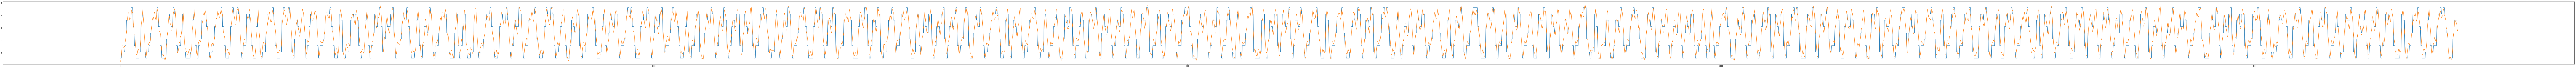

In [437]:
plt.figure(figsize=(300,7.5))
plt.plot(saxTable)
plt.plot(serie.values)
#plt.xlim(xmin=0,xmax=666)
plt.savefig('SAX L_T1.png')


In [464]:
print(serie_test.max())
print(serie_test.min())
diff_test = serie_test.max()-serie_test.min()
print(0.52+0.64666*alphabet_size)
print(diff_test/alphabet_size)
intervals_test = [serie_test.min()+i*diff/alphabet_size for i in range(alphabet_size)]
intervals_test = np.asarray(intervals_test).flatten()
intervals_test = [ i + diff_test/alphabet_size/2 for i in intervals_test]
print(intervals_test)

L_T1    6.34
dtype: float64
L_T1    0.52
dtype: float64
6.33994
L_T1    0.646667
dtype: float64
[L_T1    0.843333
dtype: float64, L_T1    1.349024
dtype: float64, L_T1    1.854715
dtype: float64, L_T1    2.360406
dtype: float64, L_T1    2.866097
dtype: float64, L_T1    3.371787
dtype: float64, L_T1    3.877478
dtype: float64, L_T1    4.383169
dtype: float64, L_T1    4.88886
dtype: float64]


In [471]:
(letters_test,indices_test)=sax.to_letter_rep(serie_test)
print(len(serie_test))
letters_test = list(letters_test)
letters_test = [ int(n) for n in letters_test]
print(len(letters_test))
print(indices_test)

2089
1460
[(0, 2), (1, 3), (2, 4), (4, 6), (5, 7), (7, 9), (8, 10), (10, 12), (11, 13), (12, 14), (14, 16), (15, 17), (17, 19), (18, 20), (20, 22), (21, 23), (22, 24), (24, 26), (25, 27), (27, 29), (28, 30), (30, 32), (31, 33), (32, 34), (34, 36), (35, 37), (37, 39), (38, 40), (40, 42), (41, 43), (42, 44), (44, 46), (45, 47), (47, 49), (48, 50), (50, 52), (51, 53), (52, 54), (54, 56), (55, 57), (57, 59), (58, 60), (60, 62), (61, 63), (62, 64), (64, 66), (65, 67), (67, 69), (68, 70), (70, 72), (71, 73), (72, 74), (74, 76), (75, 77), (77, 79), (78, 80), (80, 82), (81, 83), (82, 84), (84, 86), (85, 87), (87, 89), (88, 90), (90, 92), (91, 93), (93, 95), (94, 96), (95, 97), (97, 99), (98, 100), (100, 102), (101, 103), (103, 105), (104, 106), (105, 107), (107, 109), (108, 110), (110, 112), (111, 113), (113, 115), (114, 116), (115, 117), (117, 119), (118, 120), (120, 122), (121, 123), (123, 125), (124, 126), (125, 127), (127, 129), (128, 130), (130, 132), (131, 133), (133, 135), (134, 136), (

In [477]:
saxTable_test = []
x = 0
for i in range(len(indices_test)):
    print(indices_test[i])
    for index in range(indices_test[i][0],indices_test[i][1]-1):
        x+=1
        print(x)
        saxTable_test.append(intervals_test[letters_test[i]])
print(len(saxTable_test))
print(len(serie_test.values))

(0, 2)
1
(1, 3)
2
(2, 4)
3
(4, 6)
4
(5, 7)
5
(7, 9)
6
(8, 10)
7
(10, 12)
8
(11, 13)
9
(12, 14)
10
(14, 16)
11
(15, 17)
12
(17, 19)
13
(18, 20)
14
(20, 22)
15
(21, 23)
16
(22, 24)
17
(24, 26)
18
(25, 27)
19
(27, 29)
20
(28, 30)
21
(30, 32)
22
(31, 33)
23
(32, 34)
24
(34, 36)
25
(35, 37)
26
(37, 39)
27
(38, 40)
28
(40, 42)
29
(41, 43)
30
(42, 44)
31
(44, 46)
32
(45, 47)
33
(47, 49)
34
(48, 50)
35
(50, 52)
36
(51, 53)
37
(52, 54)
38
(54, 56)
39
(55, 57)
40
(57, 59)
41
(58, 60)
42
(60, 62)
43
(61, 63)
44
(62, 64)
45
(64, 66)
46
(65, 67)
47
(67, 69)
48
(68, 70)
49
(70, 72)
50
(71, 73)
51
(72, 74)
52
(74, 76)
53
(75, 77)
54
(77, 79)
55
(78, 80)
56
(80, 82)
57
(81, 83)
58
(82, 84)
59
(84, 86)
60
(85, 87)
61
(87, 89)
62
(88, 90)
63
(90, 92)
64
(91, 93)
65
(93, 95)
66
(94, 96)
67
(95, 97)
68
(97, 99)
69
(98, 100)
70
(100, 102)
71
(101, 103)
72
(103, 105)
73
(104, 106)
74
(105, 107)
75
(107, 109)
76
(108, 110)
77
(110, 112)
78
(111, 113)
79
(113, 115)
80
(114, 116)
81
(115, 117)
82
(117, 119)
83

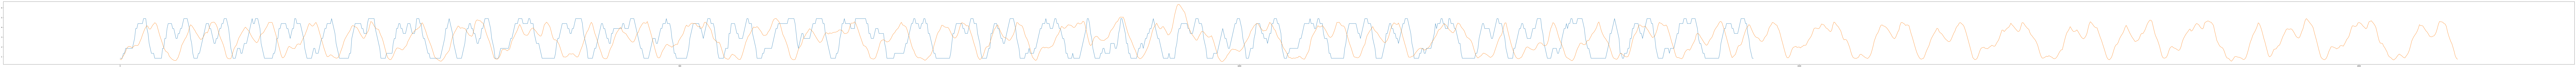

In [476]:
plt.figure(figsize=(300,7.5))
plt.plot(saxTable_test)
plt.plot(serie_test.values)


In [ ]:
n_grams_test= {}
for i in range(3,6):
    n_gram_size =i
    n_grams_test[i] = [ letters_str[i:i+n_gram_size] for i in range(len(letters_str)-n_gram_size)]
n_grams_test

In [409]:
n_grams= {}
for i in range(3,6):
    n_gram_size =i
    n_grams[i] = [ letters[i:i+n_gram_size] for i in range(len(letters)-n_gram_size)]
n_grams

{3: ['172',
  '724',
  '242',
  '427',
  '271',
  '713',
  '136',
  '363',
  '631',
  '313',
  '133',
  '335',
  '352',
  '527',
  '272',
  '725',
  '256',
  '563',
  '634',
  '343',
  '431',
  '317',
  '172',
  '725',
  '256',
  '563',
  '635',
  '354',
  '546',
  '462',
  '627',
  '272',
  '723',
  '231',
  '317',
  '172',
  '724',
  '243',
  '437',
  '374',
  '746',
  '461',
  '617',
  '172',
  '724',
  '243',
  '435',
  '352',
  '527',
  '271',
  '713',
  '133',
  '331',
  '314',
  '141',
  '417',
  '171',
  '715',
  '155',
  '553',
  '535',
  '352',
  '527',
  '271',
  '715',
  '156',
  '562',
  '624',
  '243',
  '435',
  '351',
  '517',
  '172',
  '724',
  '244',
  '445',
  '452',
  '527',
  '271',
  '715',
  '156',
  '564',
  '646',
  '462',
  '627',
  '272',
  '723',
  '232',
  '323',
  '234',
  '345',
  '453',
  '535',
  '353',
  '536',
  '364',
  '645',
  '452',
  '527',
  '271',
  '714',
  '144',
  '445',
  '452',
  '527',
  '271',
  '715',
  '156',
  '563',
  '635',
  '351'

In [410]:
n_grams_counters ={}
for n_gram in n_grams :
    n_grams_counters[n_gram] = Counter(n_grams[n_gram])


[(0.32, 1), (0.33, 1), (0.38, 1), (0.4, 2), (0.41, 3), (0.42, 1), (0.43, 4), (0.44, 4), (0.45, 1), (0.46, 4), (0.47, 1), (0.48, 4), (0.49, 5), (0.5, 5), (0.51, 4), (0.52, 4), (0.53, 3), (0.54, 4), (0.55, 7), (0.56, 8), (0.57, 11), (0.58, 9), (0.59, 6), (0.6, 6), (0.61, 9), (0.62, 16), (0.63, 11), (0.64, 11), (0.65, 7), (0.66, 7), (0.67, 12), (0.68, 13), (0.69, 11), (0.7, 10), (0.71, 19), (0.72, 21), (0.73, 22), (0.74, 22), (0.75, 17), (0.76, 14), (0.77, 30), (0.78, 23), (0.79, 24), (0.8, 26), (0.81, 20), (0.82, 20), (0.83, 34), (0.84, 26), (0.85, 27), (0.86, 26), (0.87, 31), (0.88, 36), (0.89, 30), (0.9, 24), (0.91, 24), (0.92, 35), (0.93, 30), (0.94, 31), (0.95, 29), (0.96, 29), (0.97, 34), (0.98, 36), (0.99, 37), (1.0, 35), (1.01, 32), (1.02, 29), (1.03, 28), (1.04, 18), (1.05, 26), (1.06, 26), (1.07, 23), (1.08, 23), (1.09, 17), (1.1, 14), (1.11, 18), (1.12, 29), (1.13, 20), (1.14, 14), (1.15, 31), (1.16, 20), (1.17, 15), (1.18, 21), (1.19, 31), (1.2, 25), (1.21, 21), (1.22, 17), (1

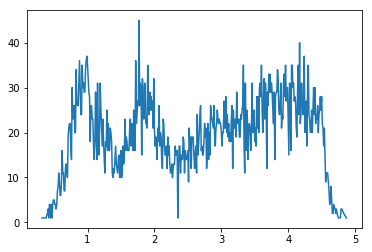

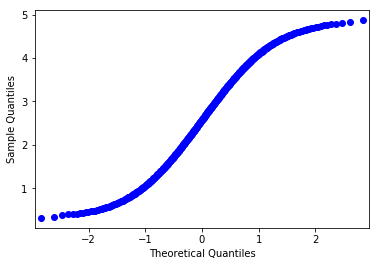

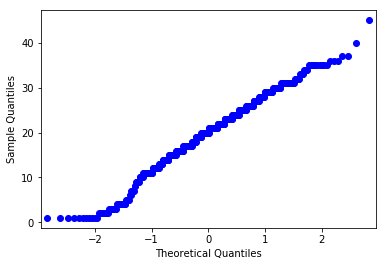

In [404]:
x,y = zip(*lists)
print(lists)
print(x)
plt.plot(x,y)
sm.qqplot(np.array(x))
sm.qqplot(np.array(y))
plt.show()


In [411]:
(letters_test,indices_test)=sax.to_letter_rep(serie_test)
letters_test = list(letters_test)
letters_test = [ int(n) for n in letters_test]
n_grams_test= {}
for i in range(3,6):
    n_gram_size =i
    n_grams_test[i] = [ letters_str[i:i+n_gram_size] for i in range(len(letters_str)-n_gram_size)]
n_grams_test

{3: ['172',
  '724',
  '242',
  '427',
  '271',
  '713',
  '136',
  '363',
  '631',
  '313',
  '133',
  '335',
  '352',
  '527',
  '272',
  '725',
  '256',
  '563',
  '634',
  '343',
  '431',
  '317',
  '172',
  '725',
  '256',
  '563',
  '635',
  '354',
  '546',
  '462',
  '627',
  '272',
  '723',
  '231',
  '317',
  '172',
  '724',
  '243',
  '437',
  '374',
  '746',
  '461',
  '617',
  '172',
  '724',
  '243',
  '435',
  '352',
  '527',
  '271',
  '713',
  '133',
  '331',
  '314',
  '141',
  '417',
  '171',
  '715',
  '155',
  '553',
  '535',
  '352',
  '527',
  '271',
  '715',
  '156',
  '562',
  '624',
  '243',
  '435',
  '351',
  '517',
  '172',
  '724',
  '244',
  '445',
  '452',
  '527',
  '271',
  '715',
  '156',
  '564',
  '646',
  '462',
  '627',
  '272',
  '723',
  '232',
  '323',
  '234',
  '345',
  '453',
  '535',
  '353',
  '536',
  '364',
  '645',
  '452',
  '527',
  '271',
  '714',
  '144',
  '445',
  '452',
  '527',
  '271',
  '715',
  '156',
  '563',
  '635',
  '351'

In [412]:
n_grams

{3: ['172',
  '724',
  '242',
  '427',
  '271',
  '713',
  '136',
  '363',
  '631',
  '313',
  '133',
  '335',
  '352',
  '527',
  '272',
  '725',
  '256',
  '563',
  '634',
  '343',
  '431',
  '317',
  '172',
  '725',
  '256',
  '563',
  '635',
  '354',
  '546',
  '462',
  '627',
  '272',
  '723',
  '231',
  '317',
  '172',
  '724',
  '243',
  '437',
  '374',
  '746',
  '461',
  '617',
  '172',
  '724',
  '243',
  '435',
  '352',
  '527',
  '271',
  '713',
  '133',
  '331',
  '314',
  '141',
  '417',
  '171',
  '715',
  '155',
  '553',
  '535',
  '352',
  '527',
  '271',
  '715',
  '156',
  '562',
  '624',
  '243',
  '435',
  '351',
  '517',
  '172',
  '724',
  '244',
  '445',
  '452',
  '527',
  '271',
  '715',
  '156',
  '564',
  '646',
  '462',
  '627',
  '272',
  '723',
  '232',
  '323',
  '234',
  '345',
  '453',
  '535',
  '353',
  '536',
  '364',
  '645',
  '452',
  '527',
  '271',
  '714',
  '144',
  '445',
  '452',
  '527',
  '271',
  '715',
  '156',
  '563',
  '635',
  '351'

In [413]:
len(n_grams[3])

362

In [414]:
len(n_grams_test[3])

362

In [415]:
n_grams==n_grams_test

True

In [416]:
n_grams[3] == n_grams_test[3]

True